In [1]:
from pathinit import *

import numpy as np

# Simple Gaussian process class & utils
from gaussproc import *

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18
import matplotlib.patches as mpatches
import corner
import arviz as az

# Librairies "non JAX" de GP
import GPy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

KeyboardInterrupt: 

In [2]:
import matplotlib as mpl

In [3]:
mpl.__version__

'3.5.1'

# Thème: usage simple des Gaussian processes (codage maison avec Numpyro)

On se sert du use-case du notebook `JAX-Optim-regression`.

In [12]:
def plot_params_kde(samples,hdi_probs=[0.393, 0.865, 0.989], 
                    patName=None, fname=None, pcut=None,
                   var_names=None, point_estimate="median", figsize=(8,8)):
        
    samples = {n:samples[n] for n in var_names}
    if pcut is not None:
        low = pcut[0]
        up  = pcut[1] 
        #keep only data in the [low, up] percentiles ex. 0.5, 99.5
        samples={name:value[(value>np.percentile(value,low)) &  (value<np.percentile(value,up))] \
          for name, value in samples.items()}
        len_min = np.min([len(value) for name, value in samples.items()])
        len_max = np.max([len(value) for name, value in samples.items()])
        if (len_max-len_min)>0.01*len_max:
            print(f"Warning: pcut leads to min/max spls size = {len_min}/{len_max}")
        samples = {name:value[:len_min] for name, value in samples.items()}
    
    axs= az.plot_pair(
            samples,
            var_names=var_names,
            kind="kde",
            figsize=figsize,
    #        marginal_kwargs={"plot_kwargs": {"lw": 3, "c": "b"}},
            kde_kwargs={
#                "hdi_probs": [0.68, 0.9],  # Plot 68% and 90% HDI contours
                "hdi_probs":hdi_probs,  # 1, 2 and 3 sigma contours
                "contour_kwargs":{"colors":('r', 'green', 'blue'), "linewidths":3},
                "contourf_kwargs":{"alpha":0},
            },
            point_estimate_kwargs={"lw": 3, "c": "b"},
            marginals=True, textsize=20, point_estimate=point_estimate
        );
    
    plt.tight_layout()
    
    if patName is not None:
        patName_patch = mpatches.Patch(color='b', label=patName)
        axs[0,0].legend(handles=[patName_patch], fontsize=40, bbox_to_anchor=(1, 0.7));
    if fname is not None:
        plt.savefig(fname)
        plt.close()

In [13]:
def mean_fn(x, params):
    """Parametrisation avant et apres (t=0) """
    R0 = params["R0"]
    v  = params["v"]
    k  = params["k"]
    tau =  params["tau"]
    return jnp.where(x < 0, R0 + v*x, R0 + v*x - k*(1.-jnp.exp(-x/tau)))

In [14]:
rng_key = jax.random.PRNGKey(42)
rng_key, rng_key0, rng_key1, rng_key2 = jax.random.split(rng_key, 4)

In [124]:
n_dataset = 20
tMes = jax.random.uniform(rng_key0,minval=-5.,maxval=5.0,shape=(n_dataset,))
tMes=jnp.append(tMes,0.0)
tMes=jnp.sort(tMes)

In [125]:
par_true={"R0":35.0, "v":2.20, "k":15.5, "tau": 1.0}
sigma_obs=1.0

In [126]:
RMes = mean_fn(tMes,par_true) + sigma_obs * jax.random.normal(rng_key1,shape=tMes.shape)

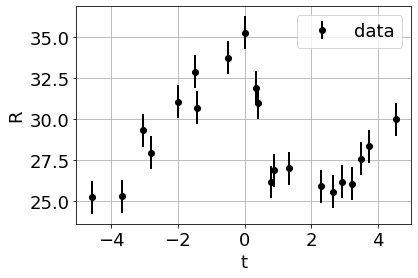

In [127]:
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

# On va se servir d'une implémentation JAX/Numpyro d'un GP

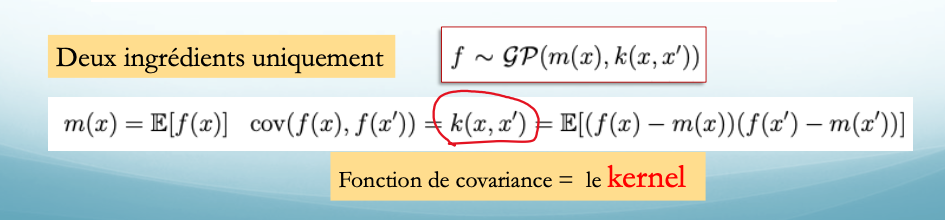

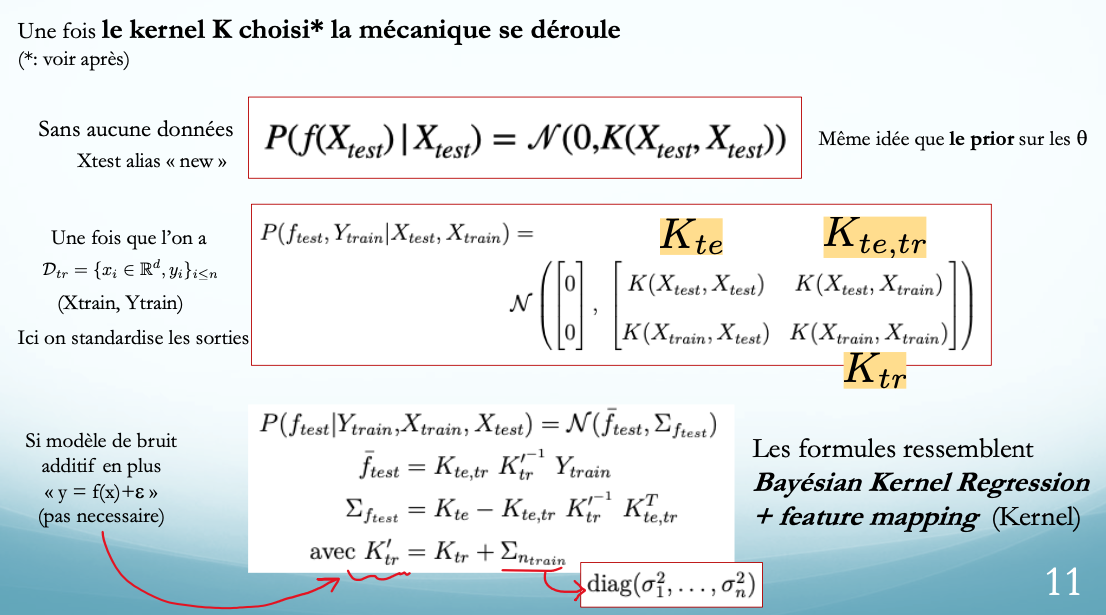

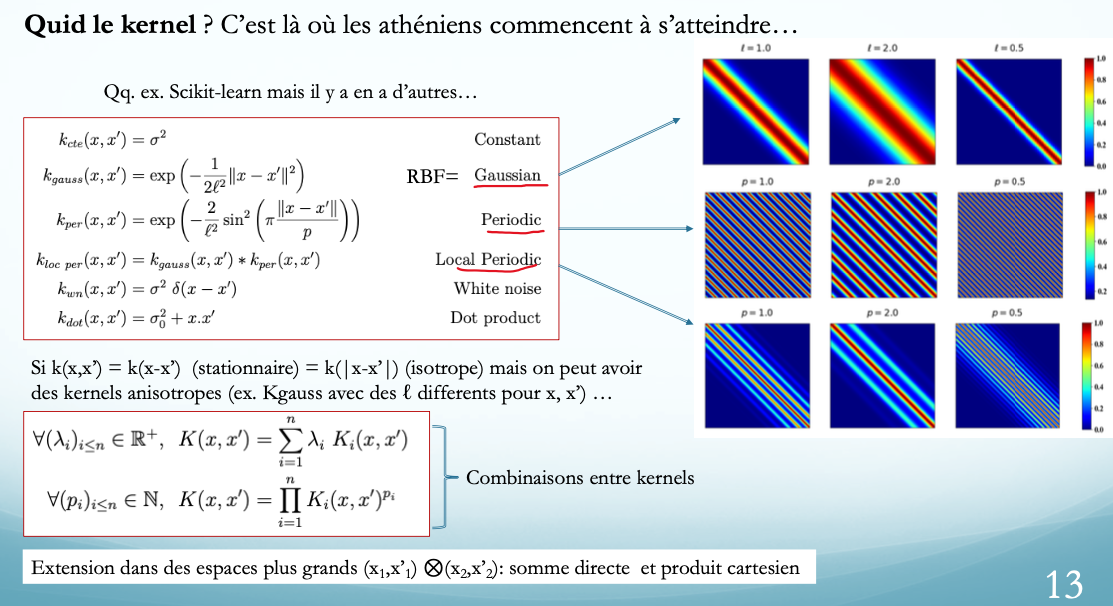

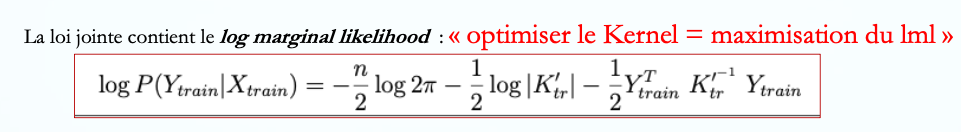

## Ouvrons ensemble le fichier `gaussproc.py` et vous allez vous rendre compte que vous `comprenez le code` (incroyable! Bravo!)

# Les priors...
Connaissant le sigma sur les données, on utilise `numpyro.deterministic`

In [128]:
def kernel_prior():
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0.1, 10))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}

def noise_prior():
    noise = numpyro.deterministic("noise",sigma_obs**2)
    return noise

gp = GaussProc(kernel=kernel_RBF, kernel_prior=kernel_prior, noise_prior=noise_prior)

# Le fit des hyperparamètres
## Ici j'ai utilisé NUTS, quelle autre méthode aurai-je pu utiliser?

In [129]:
gp.fit(rng_key2,X_train=tMes[:,jnp.newaxis],y_train=RMes, 
       num_warmup=1_000, num_samples=5_000, progress_bar=True)

sample: 100%|██████████| 6000/6000 [00:14<00:00, 416.34it/s, 3 steps of size 6.95e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      2.42      0.37      2.43      1.82      3.02   3129.50      1.00
   k_scale    173.49     65.47    161.12     76.16    259.62   3055.01      1.00

Number of divergences: 0


In [130]:
gp.get_marginal_logprob(X_train=tMes[:,jnp.newaxis],y_train=RMes)

DeviceArray(-49.26884132, dtype=float64)

In [131]:
samples = gp.get_samples()

In [132]:
samples.keys()

dict_keys(['k_length', 'k_scale', 'noise'])

In [133]:
az.ess(samples, relative=True) # nb. "noise" étant `deterministe` il faut oublier le calcul

<xarray.Dataset>
Dimensions:   ()
Data variables:
    k_length  float64 0.6621
    k_scale   float64 0.6534
    noise     float64 5e+03

 /tmp/ipykernel_1546/1475239519.py:34: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


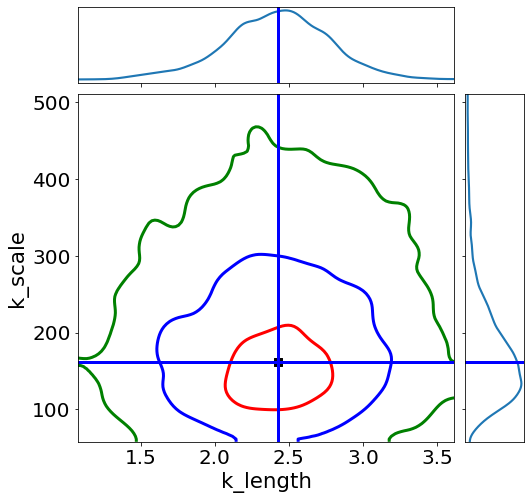

In [134]:
plot_params_kde(samples,pcut=[0,99.9],var_names=['k_length','k_scale'], figsize=(8,8))

In [135]:
rng_key, rng_key_new = jax.random.split(rng_key)

In [136]:
t_val = np.linspace(-5,5,200)

In [137]:
Rtrue_val = mean_fn(t_val,par_true)

In [138]:
means,  stds= gp.predict(rng_key_new, X_train=tMes[:,jnp.newaxis],y_train=RMes, 
                         X_new=t_val[:,jnp.newaxis])

In [139]:
means.shape

(5000, 200)

In [140]:
Rmean_val = jnp.mean(means,axis=0)

In [141]:
#percentiles = jnp.percentile(means_std, jnp.array([4.55, 31.73, 68.27, 95.45]), axis=0) 

In [142]:
std = jnp.mean(stds,axis=0)

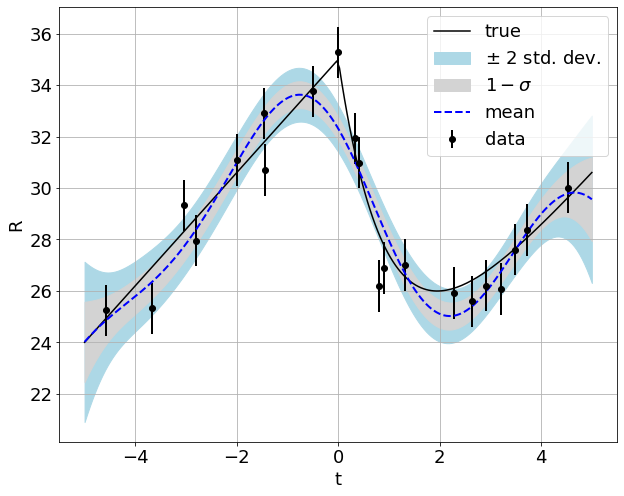

In [143]:
fig=plt.figure(figsize=(10,8))
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.plot(t_val,Rtrue_val,c='k',label="true")

plt.fill_between(t_val,Rmean_val-2*std,Rmean_val+2*std, color="lightblue", label=r"$\pm$ 2 std. dev.")
plt.fill_between(t_val, Rmean_val-std,Rmean_val+std, color="lightgray",label=r"$1-\sigma$")
# plot mean prediction
plt.plot(t_val, Rmean_val, "blue", ls="--", lw=2.0, label="mean")


plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

## Commentez la figure en comparant par exemple avec celle de `Jax-Optim-regression`?

# Voyons ce que donne Sklean

In [144]:
kernel = ConstantKernel(constant_value=100., constant_value_bounds=(10., 1000.)) * RBF(length_scale=1.0, length_scale_bounds=(0.1, 10.0))\
        + WhiteKernel(noise_level=sigma_obs**2, noise_level_bounds="fixed")

In [145]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(tMes[:,np.newaxis], RMes)

In [146]:
print(f"Kernel parameters before fit:\n{kernel})")
print(
    f"Kernel parameters after fit: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}"
)

Kernel parameters before fit:
10**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1))
Kernel parameters after fit: 
21.2**2 * RBF(length_scale=2.65) + WhiteKernel(noise_level=1) 
Log-likelihood: -55.554


In [147]:
R_mean_test, R_std_test = gpr.predict(t_val[:,jnp.newaxis], return_std=True)

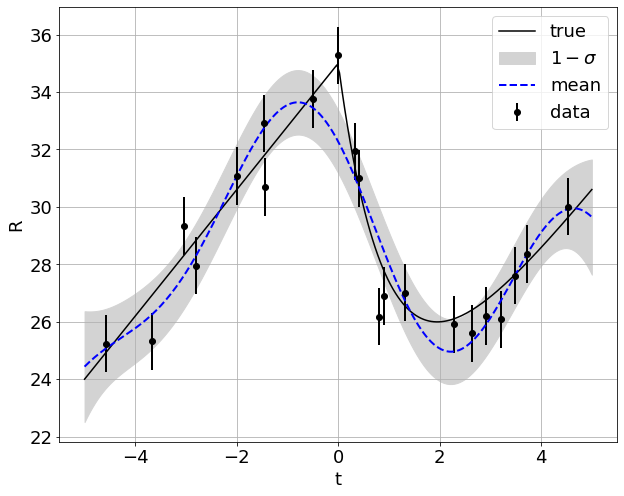

In [148]:
fig=plt.figure(figsize=(10,8))
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.plot(t_val,Rtrue_val,c='k',label="true")

plt.fill_between(t_val, R_mean_test-R_std_test, R_mean_test+R_std_test, color="lightgray",label=r"$1-\sigma$")
# plot mean prediction
plt.plot(t_val, R_mean_test, "blue", ls="--", lw=2.0, label="mean")


plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

# D'où vient la différence de largeur de la bande à 1-$\sigma$ en comparant avec le résultat obtenu avec la classe `gaussproc.py` ou les versions `Jax-Optim` `Jax-NUTS`?

# Voyons ce que donne la librairie `GPy`

In [149]:
kernel = GPy.kern.RBF(input_dim=1, variance=100., lengthscale=1.0)

In [150]:
m = GPy.models.GPRegression(tMes[:,np.newaxis], RMes[:,np.newaxis],kernel)

In [151]:
m.parameter_names()

['rbf.variance', 'rbf.lengthscale', 'Gaussian_noise.variance']

In [152]:
m['rbf.variance']

index,GP_regression.rbf.variance,constraints,priors
[0],100.00000000,+ve,


In [153]:
m['Gaussian_noise.variance'].constrain_fixed(sigma_obs**2)

array([0])

In [154]:
m['Gaussian_noise.variance']

index,GP_regression.Gaussian_noise.variance,constraints,priors
[0],1.00000000,+ve fixed,


In [155]:
m.optimize(messages=True)

In [156]:
y_mean_test, y_var_test = m.predict(t_val[:,np.newaxis])
y_mean_test_nn, y_var_test_nn = m.predict_noiseless(t_val[:,np.newaxis])

In [157]:
y_mean_test  = y_mean_test.squeeze()
y_std_test = np.sqrt(y_var_test)
y_std_test  = y_std_test.squeeze()

y_mean_test_nn  = y_mean_test_nn.squeeze()
y_std_test_nn = np.sqrt(y_var_test_nn)
y_std_test_nn  = y_std_test_nn.squeeze()

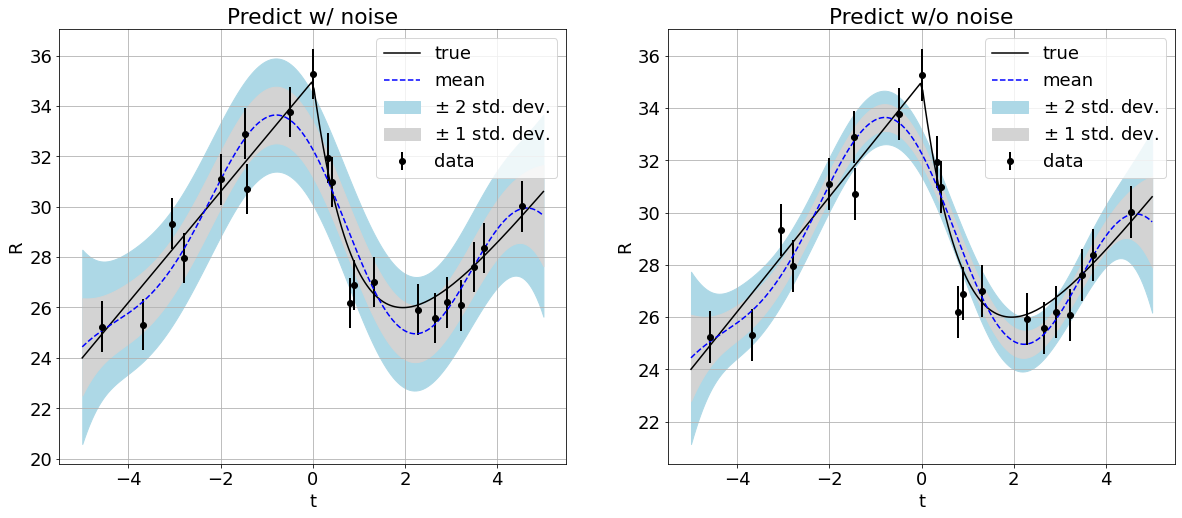

In [158]:
fig1,axs = plt.subplots(1,2,figsize=(20,8))

axs[0].errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
axs[0].plot(t_val,Rtrue_val,c='k',label="true")

axs[0].plot(t_val, y_mean_test, color="blue", ls='--', label="mean")
axs[0].fill_between(t_val,y_mean_test - 2*y_std_test,y_mean_test + 2*y_std_test,
        color="lightblue", label=r"$\pm$ 2 std. dev.")

axs[0].fill_between(t_val,y_mean_test - y_std_test,y_mean_test + y_std_test,
        color="lightgray", label=r"$\pm$ 1 std. dev." )
axs[0].set_xlabel("t")
axs[0].set_ylabel("R")
axs[0].legend()
axs[0].grid()
axs[0].set_title("Predict w/ noise");

axs[1].errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
axs[1].plot(t_val,Rtrue_val,c='k',label="true")

axs[1].plot(t_val, y_mean_test_nn, color="blue", ls='--', label="mean")
axs[1].fill_between(t_val,y_mean_test_nn - 2*y_std_test_nn,y_mean_test_nn + 2*y_std_test_nn,
        color="lightblue", label=r"$\pm$ 2 std. dev.")

axs[1].fill_between(t_val,y_mean_test_nn - y_std_test_nn,y_mean_test_nn + y_std_test_nn,
        color="lightgray", label=r"$\pm$ 1 std. dev." )
axs[1].set_xlabel("t")
axs[1].set_ylabel("R")
axs[1].legend()
axs[1].grid()
axs[1].set_title("Predict w/o noise");


##1 Donc la différence des bandes à 1-sigma (et 2-sigma aussi) vient  de ce qu'on appelle une prédiction avec un modèle de bruit des données. La version `predict` de `Sklearn` (et `GPy`) considère qu'en un nouveau point $t_{new}$ on doit donner à l'utilisateur l'idée de ce qu'il aurait eu s'il avait une mesure en ce point; tandis que `predict_noiseless` de `GPy` et `predict` de `gaussproc.py` est conforme la l'algorithme de *C. E. Rasmussen & C. K. I. Williams* qui présente la prédiction en $t_{new}$ du modèle à la manière que fait un filtre de Kalman. Le problème devient aigü quand dans Sklearn on ajoute un WhiteKernel.

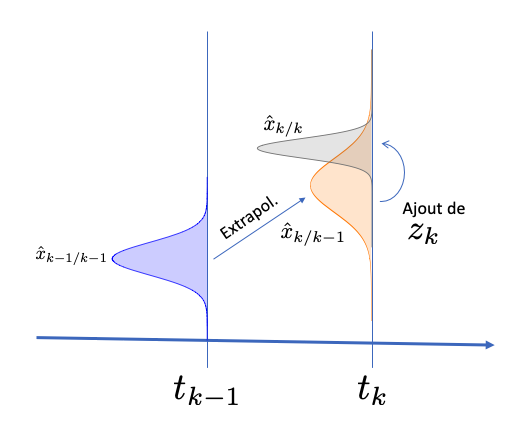

Vous pouvez lire cette issue que j'ai ouverte [ici](https://github.com/scikit-learn/scikit-learn/issues/22945) sur le Github de Sklearn.

# Q: si on change le range de [-5,5] à [-20,20] que se passe-t'il ? Pourquoi ?

# Gaussian Process avec $m(x)\neq 0$

In [159]:
def mean_fn_prior(
    R0_min=10.,v_min = 0.5,k_min = 1., tau_min=0.1,
    R0_max=50.,v_max = 3.5,k_max = 20., tau_max=5.0):
    
    R0 = numpyro.sample("R0", dist.Uniform(R0_min,R0_max))
    v  = numpyro.sample("v", dist.Uniform(v_min,v_max))
    k  = numpyro.sample("k", dist.Uniform(k_min,k_max))
    tau= numpyro.sample("tau", dist.Uniform(tau_min,tau_max))
    
    # Return sampled parameters as a dictionary
    return { "R0": R0, "v":v, "k":k, "tau":tau}


def kernel_prior():
    length = numpyro.sample("k_length", numpyro.distributions.HalfCauchy(2.))
    scale = numpyro.sample("k_scale", numpyro.distributions.HalfCauchy(2.))
    return {"k_length": length, "k_scale": scale}

def noise_prior():
    noise = numpyro.deterministic("noise",sigma_obs**2)
    return noise




In [160]:
gp = GaussProc(kernel=kernel_RBF, 
                kernel_prior=kernel_prior, 
                noise_prior=noise_prior,
                mean_fn=mean_fn,
                mean_fn_prior=mean_fn_prior)

In [161]:
rng_key = jax.random.PRNGKey(42)
rng_key, rng_key0, rng_key1, rng_key2 = jax.random.split(rng_key, 4)

# Dans un premier temps mettre `k_max=5` par exemple, et voir ce qu'il se passe, puis augmenter cette valeur (`k_max = 20` devrait aller). Regarder si les autres variables sont ok.

In [162]:
gp.fit(rng_key2,X_train=tMes[:,jnp.newaxis],y_train=RMes, 
       num_chains=1,
       chain_method='vectorized',
       num_warmup=1_000, num_samples=5_000,
       progress_bar=True)

sample: 100%|██████████| 6000/6000 [00:21<00:00, 280.19it/s, 15 steps of size 2.20e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        R0     35.33      1.60     35.34     33.08     37.71    905.35      1.00
         k     16.59      1.66     16.65     14.13     19.52   1823.95      1.00
  k_length     69.58   1719.07      4.42      0.01     27.71   2272.45      1.00
   k_scale      3.57     28.18      1.15      0.00      5.94   2174.62      1.00
       tau      0.98      0.16      0.96      0.73      1.21   1842.56      1.00
         v      2.35      0.30      2.36      1.89      2.83   2222.29      1.00

Number of divergences: 0


In [163]:
samples = gp.get_samples()

In [164]:
az.ess(samples,relative=True)

<xarray.Dataset>
Dimensions:   ()
Data variables:
    R0        float64 0.3158
    k         float64 0.2988
    k_length  float64 0.3683
    k_scale   float64 0.2568
    noise     float64 5e+03
    tau       float64 0.4296
    v         float64 0.472

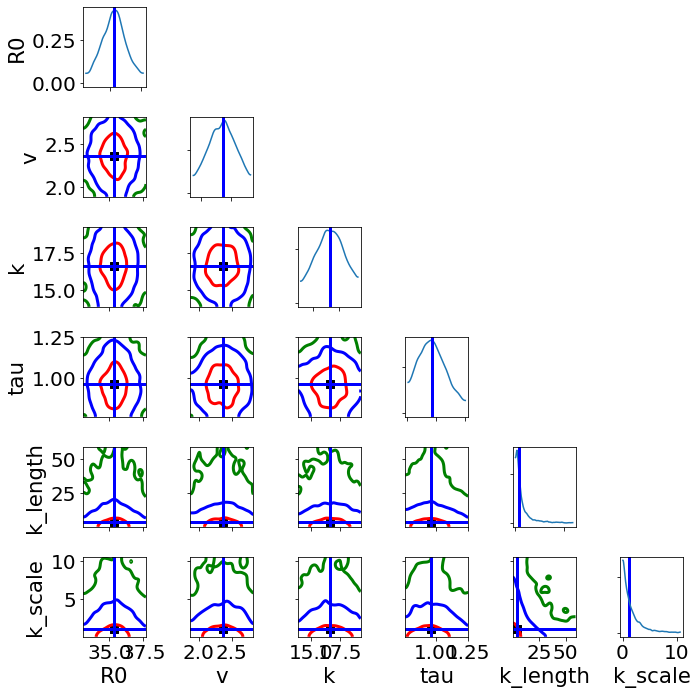

In [165]:
plot_params_kde(samples,pcut=[5,95],var_names=['R0','v','k','tau','k_length','k_scale'],figsize=(10,10))

In [166]:
means,  stds= gp.predict(rng_key_new, X_train=tMes[:,jnp.newaxis],
                         y_train=RMes, X_new=t_val[:,jnp.newaxis])

In [167]:
Rmean_val = jnp.mean(means,axis=0)
std = jnp.mean(stds,axis=0)

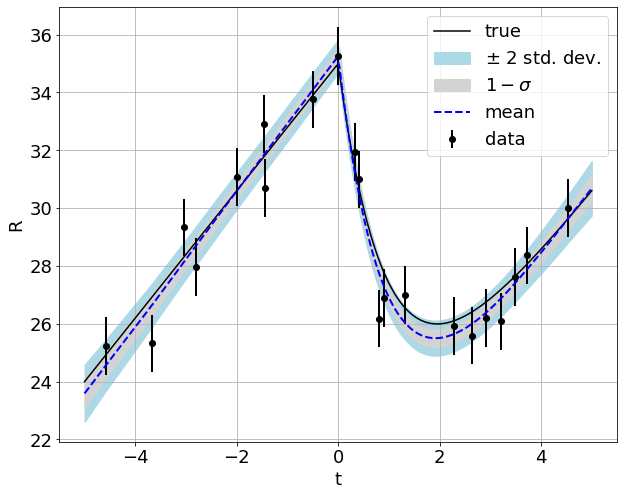

In [168]:
fig=plt.figure(figsize=(10,8))
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.plot(t_val,Rtrue_val,c='k',label="true")

plt.fill_between(t_val,Rmean_val-2*std,Rmean_val+2*std, color="lightblue", label=r"$\pm$ 2 std. dev.")
plt.fill_between(t_val, Rmean_val-std,Rmean_val+std, color="lightgray",label=r"$1-\sigma$")
# plot mean prediction
plt.plot(t_val, Rmean_val, "blue", ls="--", lw=2.0, label="mean")


plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

## Commentez la figure. 

# Exercices:
- Posez vous la question de savoir comment obtenir l'hiistogramme  sur `tmin` (voir la fin de `JAX-Optim-regression`)? 
- Dans le code de GaussProc.fit, j'ai utilisé un méthode MCMC NUTS pour ajuster les hyperparamètres du GP. Essayer de coder une méthode basée sur `jaxopt`(nb `JAX-Optim-regression`).

1-2-3 à vous de coder...

# Takeaway message
- Dans ce nb, nous n'avons pas appris de nouvelles fonctionalités de JAX car `vous en savez déjà beaucoup pour vous lancer`. Bravo!
- Concernant les GP, on peut tout à fait se faire la main en codant soit même une petite librairie qui a des fonctionalités minimales. 
- Ce faisant on découvre que `la notion de bruit des données  en lien avec la notion de prédiction` est plus délicate qu'il n'y parait et il faut faire très attention à ce que délivre finalement les librairies et on ne peut totalemen les utilsier coemme des `boites-noires`.